In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=False)

# Training

iter 1: 0.0749213
iter 2: 0.0804085
iter 3: 0.0352236
iter 4: 0.0571934
iter 5: 0.0472184
iter 6: 0.0389416
iter 7: 0.0485444
iter 8: 0.0314827
iter 9: 0.0478502
iter 10: 0.0524515
iter 11: 0.0356869
iter 12: 0.0482553
iter 13: 0.0404309
iter 14: 0.0458901
iter 15: 0.0420997
iter 16: 0.047214
iter 17: 0.0450444
iter 18: 0.0432951
iter 19: 0.0441733
iter 20: 0.0413277
iter 21: 0.0386932
iter 22: 0.0387122
iter 23: 0.0482908
iter 24: 0.0537157
iter 25: 0.0360544
iter 26: 0.041234
iter 27: 0.0397762
iter 28: 0.0383025
iter 29: 0.0403517
iter 30: 0.0383379
iter 31: 0.0416111
iter 32: 0.0392172
iter 33: 0.0406424
iter 34: 0.0324888
iter 35: 0.0420547
iter 36: 0.0476246
iter 37: 0.0353617
iter 38: 0.0446164
iter 39: 0.0412248
iter 40: 0.0391748
iter 41: 0.0361528
iter 42: 0.0411586
iter 43: 0.0398878
iter 44: 0.0407943
iter 45: 0.0342296
iter 46: 0.0350661
iter 47: 0.0390493
iter 48: 0.0454434
iter 49: 0.0395526
iter 50: 0.0412571
iter 51: 0.0414944
iter 52: 0.0418807
iter 53: 0.0377883
iter

iter 418: 0.0383091
iter 419: 0.0340712
iter 420: 0.0324295
iter 421: 0.0375864
iter 422: 0.0353963
iter 423: 0.0306871
iter 424: 0.0348822
iter 425: 0.0348096
iter 426: 0.0329413
iter 427: 0.0339275
iter 428: 0.0311022
iter 429: 0.0356918
iter 430: 0.0409997
iter 431: 0.030828
iter 432: 0.0389882
iter 433: 0.0329456
iter 434: 0.038937
iter 435: 0.0340756
iter 436: 0.0303486
iter 437: 0.0360191
iter 438: 0.0311264
iter 439: 0.0311994
iter 440: 0.0352326
iter 441: 0.0367321
iter 442: 0.0395785
iter 443: 0.0358543
iter 444: 0.0326295
iter 445: 0.0349691
iter 446: 0.0369712
iter 447: 0.0356398
iter 448: 0.0343305
iter 449: 0.0323324
iter 450: 0.0388737
iter 451: 0.0357768
iter 452: 0.031026
iter 453: 0.0334556
iter 454: 0.0336517
iter 455: 0.0339308
iter 456: 0.0343514
iter 457: 0.0359723
iter 458: 0.034823
iter 459: 0.0340442
iter 460: 0.0298408
iter 461: 0.0290622
iter 462: 0.0338199
iter 463: 0.034028
iter 464: 0.0383018
iter 465: 0.0376812
iter 466: 0.0373844
iter 467: 0.0284704
iter 

iter 832: 0.0359417
iter 833: 0.0360195
iter 834: 0.0317646
iter 835: 0.0307819
iter 836: 0.0363224
iter 837: 0.0364755
iter 838: 0.0330334
iter 839: 0.0318504
iter 840: 0.0324359
iter 841: 0.0317762
iter 842: 0.02873
iter 843: 0.0387446
iter 844: 0.028861
iter 845: 0.0280909
iter 846: 0.0412041
iter 847: 0.0327964
iter 848: 0.0310293
iter 849: 0.0301584
iter 850: 0.0279963
iter 851: 0.0335638
iter 852: 0.031716
iter 853: 0.0264025
iter 854: 0.0334077
iter 855: 0.0273979
iter 856: 0.0287352
iter 857: 0.0357007
iter 858: 0.0333167
iter 859: 0.0356092
iter 860: 0.0306147
iter 861: 0.0329208
iter 862: 0.0286802
iter 863: 0.0276178
iter 864: 0.0365344
iter 865: 0.0384386
iter 866: 0.0329178
iter 867: 0.0320183
iter 868: 0.0329634
iter 869: 0.0279989
iter 870: 0.0299491
iter 871: 0.0362001
iter 872: 0.0298068
iter 873: 0.0312294
iter 874: 0.0300146
iter 875: 0.0318453
iter 876: 0.0337742
iter 877: 0.0297199
iter 878: 0.0268261
iter 879: 0.0311196
iter 880: 0.0327532
iter 881: 0.0310818
iter

iter 1233: 0.0295751
iter 1234: 0.0361473
iter 1235: 0.033814
iter 1236: 0.0311915
iter 1237: 0.0281106
iter 1238: 0.0329284
iter 1239: 0.0323188
iter 1240: 0.0278286
iter 1241: 0.0370257
iter 1242: 0.0324925
iter 1243: 0.0314053
iter 1244: 0.0311369
iter 1245: 0.0307686
iter 1246: 0.0324026
iter 1247: 0.0308096
iter 1248: 0.0332896
iter 1249: 0.0362179
iter 1250: 0.0320596
iter 1251: 0.0294691
iter 1252: 0.0332609
iter 1253: 0.0384694
iter 1254: 0.0310715
iter 1255: 0.0310322
iter 1256: 0.0314171
iter 1257: 0.029347
iter 1258: 0.0322249
iter 1259: 0.0327531
iter 1260: 0.0287341
iter 1261: 0.038874
iter 1262: 0.028504
iter 1263: 0.0363824
iter 1264: 0.0357331
iter 1265: 0.0326946
iter 1266: 0.0323394
iter 1267: 0.0394231
iter 1268: 0.031879
iter 1269: 0.0360179
iter 1270: 0.0338237
iter 1271: 0.0344656
iter 1272: 0.0353321
iter 1273: 0.040868
iter 1274: 0.035223
iter 1275: 0.0349335
iter 1276: 0.0341671
iter 1277: 0.0327902
iter 1278: 0.0348507
iter 1279: 0.0313793
iter 1280: 0.0348288

iter 1629: 0.0102998
iter 1630: 0.011808
iter 1631: 0.0122339
iter 1632: 0.0118025
iter 1633: 0.0157522
iter 1634: 0.0165765
iter 1635: 0.0123016
iter 1636: 0.00862486
iter 1637: 0.0105547
iter 1638: 0.0104642
iter 1639: 0.00861675
iter 1640: 0.0110442
iter 1641: 0.013348
iter 1642: 0.0114991
iter 1643: 0.0144211
iter 1644: 0.0142416
iter 1645: 0.0122926
iter 1646: 0.011929
iter 1647: 0.0116291
iter 1648: 0.0117899
iter 1649: 0.0130357
iter 1650: 0.010703
iter 1651: 0.0121074
iter 1652: 0.00899158
iter 1653: 0.0108434
iter 1654: 0.0100237
iter 1655: 0.00988425
iter 1656: 0.0113319
iter 1657: 0.013583
iter 1658: 0.0105226
iter 1659: 0.0126503
iter 1660: 0.0115718
iter 1661: 0.0124901
iter 1662: 0.0141721
iter 1663: 0.00984097
iter 1664: 0.00876206
iter 1665: 0.0176598
iter 1666: 0.00755828
iter 1667: 0.0111296
iter 1668: 0.0134562
iter 1669: 0.0100576
iter 1670: 0.0118746
iter 1671: 0.0146691
iter 1672: 0.011683
iter 1673: 0.0126524
iter 1674: 0.0108023
iter 1675: 0.00941557
iter 1676: 

iter 2014: 0.00723952
iter 2015: 0.010289
iter 2016: 0.00832157
iter 2017: 0.00860362
iter 2018: 0.00765597
iter 2019: 0.0084708
iter 2020: 0.00774702
iter 2021: 0.00789892
iter 2022: 0.00725015
iter 2023: 0.00981069
iter 2024: 0.00709682
iter 2025: 0.0115442
iter 2026: 0.00788901
iter 2027: 0.00848183
iter 2028: 0.0098192
iter 2029: 0.00763737
iter 2030: 0.0115769
iter 2031: 0.012592
iter 2032: 0.0091063
iter 2033: 0.00882469
iter 2034: 0.01158
iter 2035: 0.00868839
iter 2036: 0.00978014
iter 2037: 0.00997463
iter 2038: 0.00924441
iter 2039: 0.00830327
iter 2040: 0.0110582
iter 2041: 0.00952017
iter 2042: 0.00731604
iter 2043: 0.0100552
iter 2044: 0.00851254
iter 2045: 0.0101515
iter 2046: 0.00766684
iter 2047: 0.0072456
iter 2048: 0.00955135
iter 2049: 0.00932603
iter 2050: 0.00787205
iter 2051: 0.0101373
iter 2052: 0.00859418
iter 2053: 0.00784994
iter 2054: 0.00783304
iter 2055: 0.00926431
iter 2056: 0.00799661
iter 2057: 0.00786841
iter 2058: 0.00961784
iter 2059: 0.00871097
iter 

iter 2394: 0.0071382
iter 2395: 0.0063242
iter 2396: 0.00724701
iter 2397: 0.00643761
iter 2398: 0.00646375
iter 2399: 0.00669264
iter 2400: 0.00613168
iter 2401: 0.00652884
iter 2402: 0.00672484
iter 2403: 0.0060443
iter 2404: 0.00680475
iter 2405: 0.00603148
iter 2406: 0.00697161
iter 2407: 0.0061478
iter 2408: 0.00610818
iter 2409: 0.00684585
iter 2410: 0.00632479
iter 2411: 0.0059231
iter 2412: 0.00609484
iter 2413: 0.00642482
iter 2414: 0.00606069
iter 2415: 0.00740007
iter 2416: 0.00713409
iter 2417: 0.00662159
iter 2418: 0.00625849
iter 2419: 0.00554184
iter 2420: 0.00696324
iter 2421: 0.00667719
iter 2422: 0.00526876
iter 2423: 0.00703999
iter 2424: 0.00636252
iter 2425: 0.0062814
iter 2426: 0.00490781
iter 2427: 0.00607497
iter 2428: 0.00543912
iter 2429: 0.00704789
iter 2430: 0.00616755
iter 2431: 0.00540598
iter 2432: 0.0109772
iter 2433: 0.0057039
iter 2434: 0.00803661
iter 2435: 0.00788961
iter 2436: 0.00538198
iter 2437: 0.0077426
iter 2438: 0.00689689
iter 2439: 0.009804

iter 2769: 0.00561865
iter 2770: 0.00416589
iter 2771: 0.00571608
iter 2772: 0.00563532
iter 2773: 0.00576856
iter 2774: 0.00458457
iter 2775: 0.00567228
iter 2776: 0.00506869
iter 2777: 0.00540786
iter 2778: 0.00532103
iter 2779: 0.00572387
iter 2780: 0.0054795
iter 2781: 0.00565568
iter 2782: 0.00519775
iter 2783: 0.00515181
iter 2784: 0.0063588
iter 2785: 0.00609287
iter 2786: 0.00392856
iter 2787: 0.00609423
iter 2788: 0.00684414
iter 2789: 0.00501217
iter 2790: 0.0049722
iter 2791: 0.00524519
iter 2792: 0.0059678
iter 2793: 0.00503939
iter 2794: 0.00658434
iter 2795: 0.00463719
iter 2796: 0.00552274
iter 2797: 0.00527287
iter 2798: 0.00621069
iter 2799: 0.00544078
iter 2800: 0.00470296
iter 2801: 0.00477271
iter 2802: 0.00537423
iter 2803: 0.00554855
iter 2804: 0.00462221
iter 2805: 0.00494728
iter 2806: 0.00479744
iter 2807: 0.00518298
iter 2808: 0.0042733
iter 2809: 0.0058303
iter 2810: 0.00554744
iter 2811: 0.00511036
iter 2812: 0.00472515
iter 2813: 0.00497379
iter 2814: 0.005

iter 3144: 0.00468597
iter 3145: 0.00383104
iter 3146: 0.00546646
iter 3147: 0.00412755
iter 3148: 0.00408475
iter 3149: 0.00357017
iter 3150: 0.00489786
iter 3151: 0.00413124
iter 3152: 0.00455509
iter 3153: 0.00474633
iter 3154: 0.00382957
iter 3155: 0.00461269
iter 3156: 0.00493269
iter 3157: 0.00396115
iter 3158: 0.00446555
iter 3159: 0.00532271
iter 3160: 0.00574279
iter 3161: 0.00487129
iter 3162: 0.00468487
iter 3163: 0.00672208
iter 3164: 0.00458748
iter 3165: 0.00533501
iter 3166: 0.00471382
iter 3167: 0.00499294
iter 3168: 0.00580235
iter 3169: 0.00466544
iter 3170: 0.00573478
iter 3171: 0.00672547
iter 3172: 0.00453988
iter 3173: 0.00489253
iter 3174: 0.00433317
iter 3175: 0.00488987
iter 3176: 0.00441635
iter 3177: 0.0043037
iter 3178: 0.00466058
iter 3179: 0.00648308
iter 3180: 0.00522092
iter 3181: 0.00527155
iter 3182: 0.00476585
iter 3183: 0.00435403
iter 3184: 0.00427546
iter 3185: 0.00402833
iter 3186: 0.00637515
iter 3187: 0.00607789
iter 3188: 0.0050693
iter 3189: 0

iter 3523: 0.00484279
iter 3524: 0.00434583
iter 3525: 0.00445537
iter 3526: 0.00386752
iter 3527: 0.00469386
iter 3528: 0.00394136
iter 3529: 0.0042958
iter 3530: 0.00391517
iter 3531: 0.00394703
iter 3532: 0.00403071
iter 3533: 0.00389408
iter 3534: 0.00405201
iter 3535: 0.00478289
iter 3536: 0.00396952
iter 3537: 0.0049997
iter 3538: 0.00374883
iter 3539: 0.00403425
iter 3540: 0.00394203
iter 3541: 0.00379837
iter 3542: 0.00436899
iter 3543: 0.00417379
iter 3544: 0.00469931
iter 3545: 0.00464063
iter 3546: 0.00471428
iter 3547: 0.00436553
iter 3548: 0.0047321
iter 3549: 0.00432183
iter 3550: 0.00338656
iter 3551: 0.00345066
iter 3552: 0.00413685
iter 3553: 0.00372258
iter 3554: 0.00324556
iter 3555: 0.00378819
iter 3556: 0.00429126
iter 3557: 0.00404396
iter 3558: 0.00383827
iter 3559: 0.00474568
iter 3560: 0.00480962
iter 3561: 0.00464684
iter 3562: 0.00296234
iter 3563: 0.00536139
iter 3564: 0.00446414
iter 3565: 0.00358676
iter 3566: 0.00369063
iter 3567: 0.00497642
iter 3568: 0.

iter 3899: 0.00383071
iter 3900: 0.00393997
iter 3901: 0.00378555
iter 3902: 0.00365783
iter 3903: 0.00376333
iter 3904: 0.00278818
iter 3905: 0.00362975
iter 3906: 0.00479906
iter 3907: 0.00468832
iter 3908: 0.0040489
iter 3909: 0.00325706
iter 3910: 0.00293279
iter 3911: 0.00523686
iter 3912: 0.00287904
iter 3913: 0.00479463
iter 3914: 0.00345227
iter 3915: 0.00397119
iter 3916: 0.0036543
iter 3917: 0.00298377
iter 3918: 0.00341332
iter 3919: 0.00369135
iter 3920: 0.0045236
iter 3921: 0.00391983
iter 3922: 0.00386578
iter 3923: 0.00341988
iter 3924: 0.00398084
iter 3925: 0.00425794
iter 3926: 0.00340587
iter 3927: 0.00322458
iter 3928: 0.00333517
iter 3929: 0.00481457
iter 3930: 0.00301473
iter 3931: 0.00401139
iter 3932: 0.00429381
iter 3933: 0.00427267
iter 3934: 0.00345986
iter 3935: 0.00402768
iter 3936: 0.00343722
iter 3937: 0.00360765
iter 3938: 0.00299117
iter 3939: 0.00369866
iter 3940: 0.00356342
iter 3941: 0.00395547
iter 3942: 0.00431659
iter 3943: 0.00273831
iter 3944: 0.

iter 4279: 0.00361439
iter 4280: 0.00255292
iter 4281: 0.00379854
iter 4282: 0.00309949
iter 4283: 0.0034242
iter 4284: 0.00411099
iter 4285: 0.00288556
iter 4286: 0.00343307
iter 4287: 0.00365757
iter 4288: 0.00378742
iter 4289: 0.00431915
iter 4290: 0.00430071
iter 4291: 0.00307612
iter 4292: 0.00468209
iter 4293: 0.00365721
iter 4294: 0.0037718
iter 4295: 0.00343573
iter 4296: 0.00314723
iter 4297: 0.0027546
iter 4298: 0.00342096
iter 4299: 0.00300558
iter 4300: 0.0027495
iter 4301: 0.00365234
iter 4302: 0.00403568
iter 4303: 0.00381098
iter 4304: 0.00349781
iter 4305: 0.00310733
iter 4306: 0.00302057
iter 4307: 0.00466169
iter 4308: 0.00346579
iter 4309: 0.00416467
iter 4310: 0.00363996
iter 4311: 0.00331282
iter 4312: 0.00328018
iter 4313: 0.00292989
iter 4314: 0.00457825
iter 4315: 0.00336128
iter 4316: 0.00349563
iter 4317: 0.00366098
iter 4318: 0.00309056
iter 4319: 0.0033892
iter 4320: 0.0035577
iter 4321: 0.00382995
iter 4322: 0.0036947
iter 4323: 0.0039345
iter 4324: 0.00361

iter 4655: 0.0035413
iter 4656: 0.00344358
iter 4657: 0.00385519
iter 4658: 0.00309936
iter 4659: 0.004334
iter 4660: 0.00376391
iter 4661: 0.00456772
iter 4662: 0.00287996
iter 4663: 0.00314497
iter 4664: 0.00316299
iter 4665: 0.00374054
iter 4666: 0.00336178
iter 4667: 0.00331744
iter 4668: 0.00455261
iter 4669: 0.00317501
iter 4670: 0.00420898
iter 4671: 0.00452086
iter 4672: 0.00364852
iter 4673: 0.00467841
iter 4674: 0.00459416
iter 4675: 0.00385757
iter 4676: 0.00431537
iter 4677: 0.00550819
iter 4678: 0.00477958
iter 4679: 0.00502059
iter 4680: 0.00389393
iter 4681: 0.00558792
iter 4682: 0.00415627
iter 4683: 0.00514254
iter 4684: 0.00460989
iter 4685: 0.00446433
iter 4686: 0.00372412
iter 4687: 0.00391729
iter 4688: 0.00375069
iter 4689: 0.00281625
iter 4690: 0.00435082
iter 4691: 0.00399202
iter 4692: 0.00390272
iter 4693: 0.00503868
iter 4694: 0.00355186
iter 4695: 0.0031078
iter 4696: 0.00360634
iter 4697: 0.00370976
iter 4698: 0.00349496
iter 4699: 0.00305749
iter 4700: 0.0

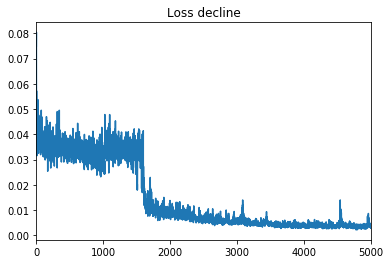

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2
print("Threshold: ",threshold)

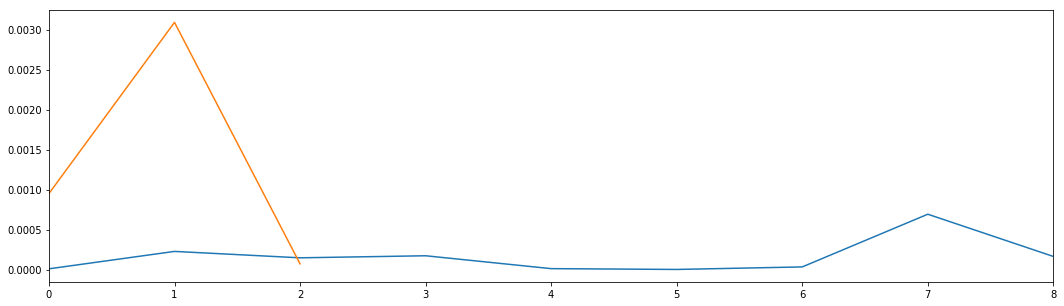

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized


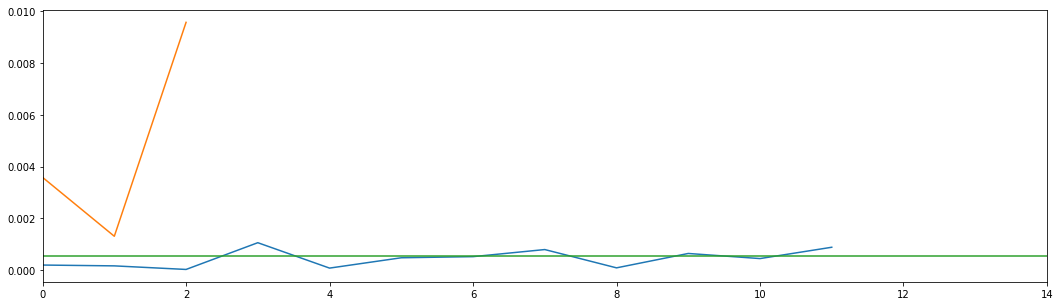

In [14]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

            
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [15]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9869706840390879

In [16]:
print(tp,fp,tn,fn,P,R)

3 0 8 4 1.0 0.42857142857142855
